In [1]:
import numpy as np
import pandas as pd
import os

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
from matplotlib import pyplot as plt

In [6]:
labels_df = pd.read_csv('train_v2.csv')
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: f"{x}.jpg")

In [7]:
data_dir = 'D:/DOWNLOADS/train-jpg/train-jpg'

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
batch_size = 32
target_size =(224,224)

In [12]:
generator = datagen.flow_from_dataframe(
    dataframe = labels_df,
    directory = data_dir,
    x_col= 'image_name',
    y_col= None,
    target_size = target_size,
    batch_size = batch_size,
    shuffle=False,
    class_mode = None)

Found 40479 validated image filenames.


In [13]:
first_batch = next(generator)
print(f"First batch shape: {first_batch.shape}")

First batch shape: (32, 224, 224, 3)


In [14]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)

In [16]:
features = feature_extractor.predict(first_batch, batch_size=32, verbose=3)
print(f"Extracted features shape: {features.shape}")

Extracted features shape: (32, 2048)


In [17]:
features = feature_extractor.predict(generator, verbose=1)
print(f"Extracted features shape: {features.shape}")

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1265/1265 ━━━━━━━━━━━━━━━━━━━━ 2270s 2s/step
Extracted features shape: (40479, 2048)


In [18]:
pca = PCA(n_components=50)  
reduced_features = pca.fit_transform(features)
print(f"Reduced features shape after PCA: {reduced_features.shape}")

Reduced features shape after PCA: (40479, 50)


In [19]:
num_clusters = 5 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_features)

In [20]:
labels_df['cluster'] = labels
print("Cluster labels added to the dataframe:")
print(labels_df[['image_name', 'cluster']].head())

Cluster labels added to the dataframe:
    image_name  cluster
0  train_0.jpg        0
1  train_1.jpg        3
2  train_2.jpg        4
3  train_3.jpg        4
4  train_4.jpg        3


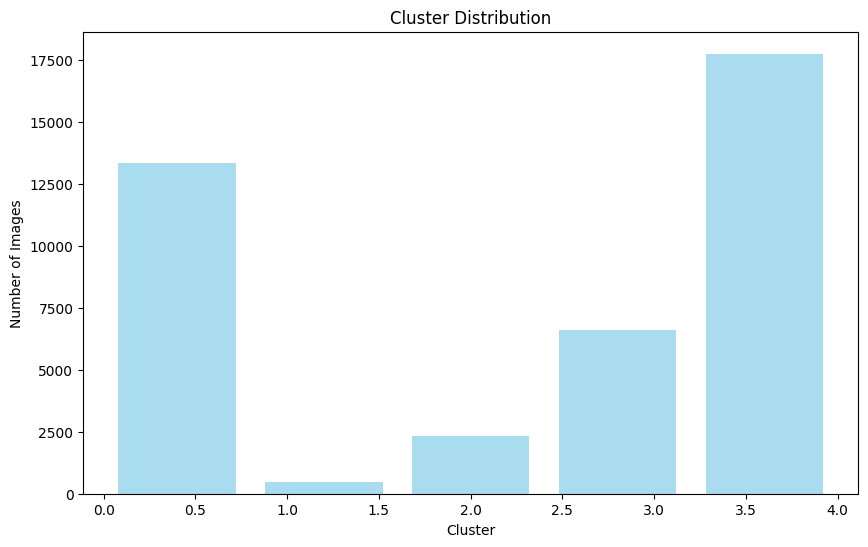

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=num_clusters, rwidth=0.8, color='skyblue', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.title("Cluster Distribution")
plt.show()

In [27]:
def visualize_cluster_images(cluster_num, num_images=5):
    cluster_images = labels_df[labels_df['cluster'] == cluster_num]['image_name'].values[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(cluster_images):
        img_path = os.path.join(data_dir, img_name)
        img = image.load_img(img_path, target_size=target_size)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Cluster {cluster_num}")
    plt.show()

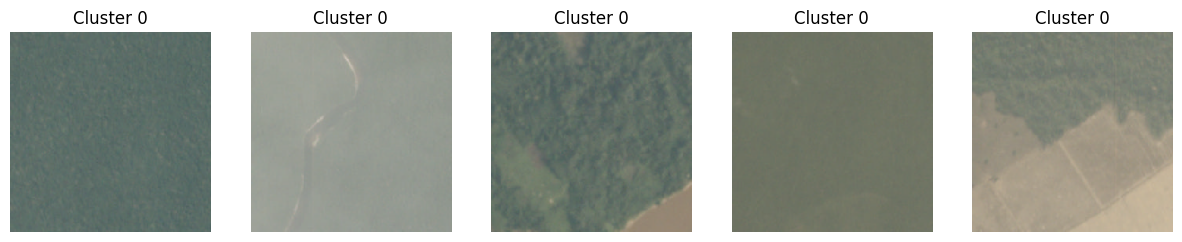

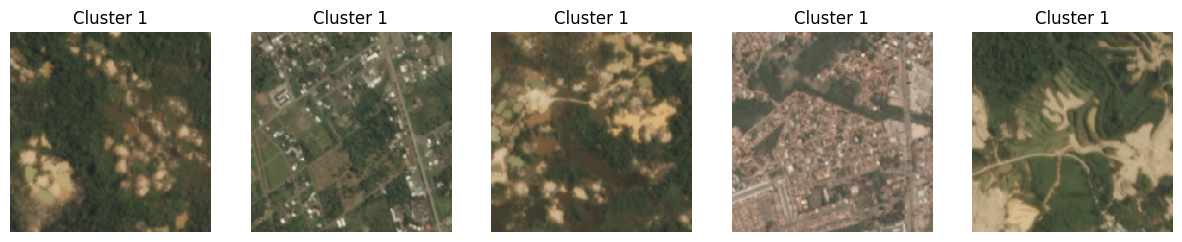

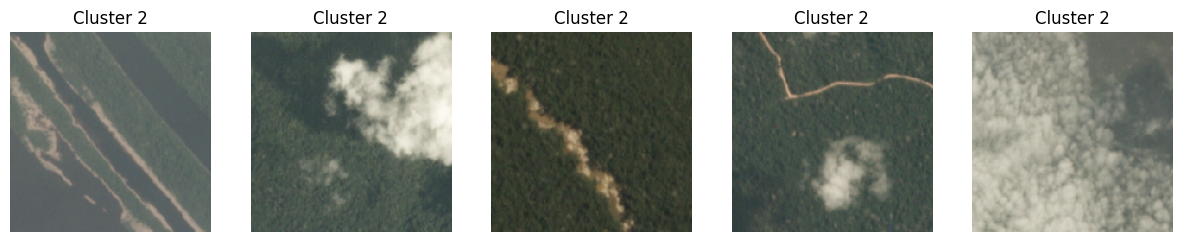

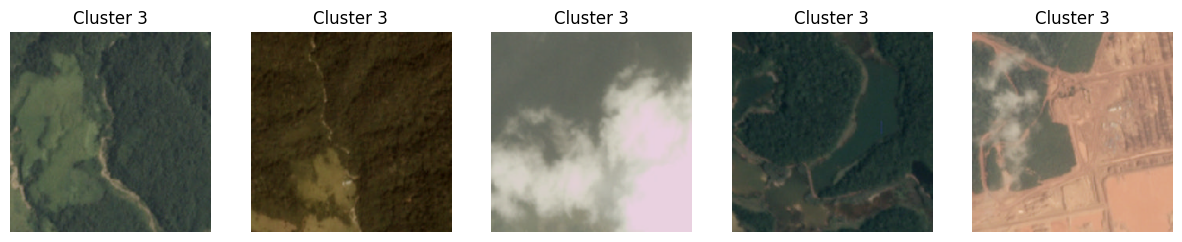

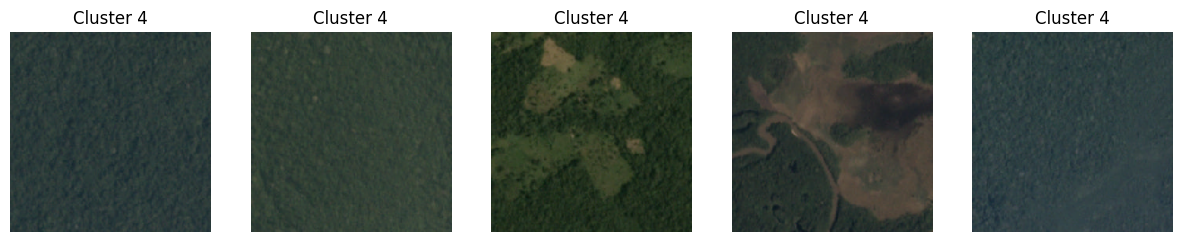

In [28]:
for cluster in range(num_clusters):
    visualize_cluster_images(cluster)